### AST 5731 
#### Group 3 - Project 3
#### Group Members: Thomas Atkins, Tyler Barna, Tore Boybei, and Haowen Zhong

##### Contents

 1. [Introduction](#introduction)
 2. [Data](#data)  
    2.1 [Importing Data](#importing-data)    
    2.2 [Data Visualization](#visualization)
 3. [Analysis](#analysis)   
    3.1 [Components of Statistical Model](#model)  
    3.2 [Prior Predictive Check](#prior)     
    3.3 [Posterior](#posterior)     
    3.4 [Sensitivity Analysis](#senstivity)  
    3.5 [Posterior Predictive Check](#ppc)   
 4. [Results](#results)

### 1. Introduction 
<a id='introduction'></a>

Gamma Ray Bursts (GRBs) are some of the most energetic transient events observed in the universe. They are thought to be the result of high energy collapses of massive stars (called supernova), as well as the merger of neutron stars and black holes (called kilonova). Generally, they're observed as brief events followed by an afterglow in other observation bands. Because GRBs are so energetic, we can observe GRBs at cosmological distances. Amusingly, GRBs were first discovered incidentally as part of a covert nuclear weapons testing detection satellite program, but it wasn't until the late 90s that GRB afterglows were detected in the optical and X-ray bands.

One key feature of GRBs in relation to contemporary astronomy is their association with gravitational waves. Kilonovae are capable of being detected by current gravitational wave detectors, and the localization of a gravitational wave event can be improved by the localization of an associated GRB. In the current era of rapidly-growing multi-messenger astronomy, GRBs have become increasingly important for localizing potential gravitational wave sources on the sky. Because of this, it is more important than ever to understand the nature of GRBs. One ongoing area of discussion is the duration of GRBs. There are two primary classes of GRBs, short and long GRBs (SGRBs and LGRBs, respectively) (there are also a sub-class of GRB called ultra-long GRBs, but these are extremely rare, even in the context of GRBs, and are outside the scope of this study). The division between SGRBs and LGRBs is traditionally accepted as being a duration of ~2 seconds. This results in a bimodal distribution well-suited to a Bayesian mixture model. We follow a similar procedure to that outlined in [Zhang et al. 2008 ](https://www.aanda.org/articles/aa/pdf/2008/23/aa9210-07.pdf).

In this analysis, we estimate the parameters as well of this mixture model in a Bayesian context. Furthermore, we compute a distribution of the division between SBRBs and LGRBs, to investigate whether the traditional value of 2s is supported by the data.

### 2. Data
<a id='data'></a>

Importing packages used for the project: 

In [18]:
import csv
import dis
import inspect
import os
import sys
import time

import astropy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
import arviz as az
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from IPython.display import display_html
from IPython.display import Image

from numpy import interp

from scipy import integrate
from scipy import linalg as la
from scipy import optimize

from scipy.stats import beta
from scipy.stats import betabinom
from scipy.stats import binom
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import multivariate_normal as mvn
from scipy.stats import nbinom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import t
from scipy.stats import uniform

from sklearn import preprocessing as pp
from sklearn.neighbors import KernelDensity

%matplotlib inline
plt.style.use("seaborn-colorblind")
mpl.rcParams.update({"axes.grid" : False})
plt.style.context(("seaborn-colorblind",))
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
## set seed for reproducibility
random.seed(5731)

#### 2.1 Importing Data
<a id='importing'></a>  

We retrieve our data from the [NASA Swift Archive ](https://swift.gsfc.nasa.gov/archive/grb_table.html/). There are a number of observables provided in the data, but our analysis is primarly concerned with the "T90" column. This corresponds to the duration of the GRB in seconds. We import the data using the pandas package, and then convert the data to a numpy array for use in our analysis. 

One thing to note is that the data is not uniformly formatted - there are several instances where T90 values are quoted as a range or an approximation (eg "1-2" or "~1.5"). We have chosen to ignore these values, as they are not well-defined. Even excluding these values, we still have a significantly larger pool of data compared to the original study by Zhang et al. (2008) - we have almost 1500 GRBs for analysis, compared to the 95 used in the original study.

*Note: in the context of this analysis, log will always refer to log base 10, following the convention of Zhang et. al.*

Number of observations: 1447


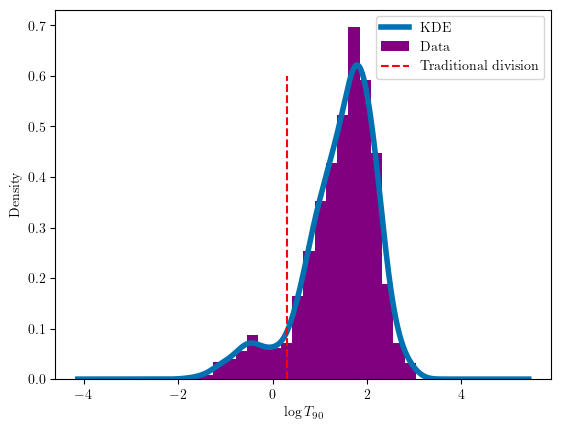

In [19]:
df = pd.read_csv("swiftGRBData.txt", sep="\t")
times = np.array(df['BAT T90 [sec]'].dropna())
data = []
for i in times:
  try:
    data.append(float(i))
  except:
    continue
times = np.array(data)
  
print(f"Number of observations: {len(times)}")

time_df = pd.DataFrame(np.log10(times), columns=["KDE"])
time_df.plot.kde(linewidth = 4)
hist = plt.hist(np.log10(times),density=True,bins=20,color= 'purple', label='Data')
plt.xlabel(r'$\log T_{90}$')
plt.vlines([np.log10(2)], 0, 0.6, color='r', linestyles='--', label='Traditional division')
plt.legend()
plt.show()

There are significantly more LGRBs than SGRBs in the dataset; even with the KDE, we can see that the 2 second division point is plausible, but further analysis is required to determine whether this is the best division point.

### 3. Bayesian Analysis
<a id='analysis'></a>

#### 3.1 Components of Statistical Model
<a id='model'></a>

Our Gaussian mixture model is as follows. We assume that $X=\log(T_{90})$ arises as a result of a mixture of two Gaussian distributions.

$$
X | z_i = 0 \sim N(\mu_1, \tau_1)
$$
$$
X | z_i = 1 \sim N(\mu_2, \tau_2)
$$
$$
\mu_1, \mu_2 \sim N(\pm 1, 10)
$$
$$
\tau_1, \tau_2 \sim Gamma(1,1)
$$
$$
w\sim \text Dir(\alpha)
$$
$$
z_i|w_k \sim Cat(w)
$$

We choose $\alpha=1$ for our Dirichlet prior. We choose -2 and 2 for the center of our mean priors to ensure that $\mu_1<\mu_2$ for all chains.

##### Model Assumptions

We assume that the true distribution of Gamma Ray burst times follows a mixture of two log normal distributions.

In [ ]:
# Mixture of Normal and Normal variables
with pm.Model() as model:
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # 2 mixture weights

    mu1 = pm.Normal("mu1", -2, 10)
    mu2 = pm.Normal("mu2", 2, 10)

    tau1 = pm.Gamma('tau1', alpha=1, beta=1)
    tau2 = pm.Gamma('tau2', alpha=1, beta=1)

    components = [
        pm.Normal.dist(mu=mu1, tau=tau1),
        pm.Normal.dist(mu=mu2, tau=tau2)
    ]

    like = pm.Mixture('like', w=w, comp_dists=components, observed=np.log10(times))
    idata = pm.sample_prior_predictive(samples=50)

Sampling: [like, mu1, mu2, tau1, tau2, w]


#### 3.2 Prior Predicitive Check
<a id='prior'></a>

We sample from our prior distribution to ensure that our data could be generated by our model.

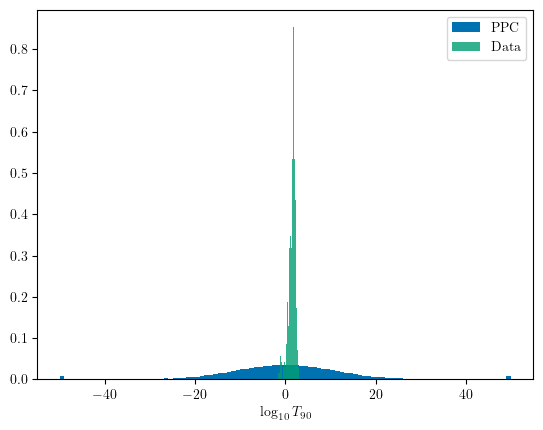

In [ ]:
msim = int(1e5)

mu1 = norm.rvs(loc=-2, scale=10, size=msim)
mu2 = norm.rvs(loc=2, scale=10, size=msim)
tau1 = gamma.rvs(a=1, scale=1, size=msim)
tau2 = gamma.rvs(a=1, scale=1, size=msim)
switch = uniform.rvs(size=msim)>0.5

mu = mu1
mu[switch] = mu2[switch]
tau = tau1
tau[switch] = tau2[switch]

data = norm.rvs(loc=mu, scale=1/tau)
data = np.clip(data, -50, 50)
plt.hist(data, bins=100, density=True, label="PPC")
plt.hist(np.log10(times), bins=100, density=True, label="Data", alpha=0.8)
plt.legend()
plt.xlabel('$\log_{10} T_{90}$')
plt.show()

Our model passes the prior predictive check, as our data clearly could have been generated by our model.

#### 3.3 Posterior 
<a id='posterior'></a>

We sample from our model using the NUTS sampler.

In [ ]:
with model:
      trace = pm.sample(draws=5000,return_inferencedata=True,
                        chains=4, cores=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [w, mu1, mu2, tau1, tau2]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 31 seconds.


We print the summary of the trace below.

In [ ]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,0.033,0.244,-0.394,0.481,0.004,0.003,3798.0,6875.0,1.0
mu2,1.641,0.031,1.584,1.696,0.000,0.000,4388.0,7547.0,1.0
w[0],0.152,0.040,0.088,0.228,0.001,0.000,3778.0,6415.0,1.0
w[1],0.848,0.040,0.772,0.912,0.001,0.000,3778.0,6415.0,1.0
tau1,1.935,0.629,0.982,3.093,0.010,0.007,4132.0,6799.0,1.0
tau2,3.701,0.294,3.170,4.248,0.004,0.003,4472.0,7338.0,1.0


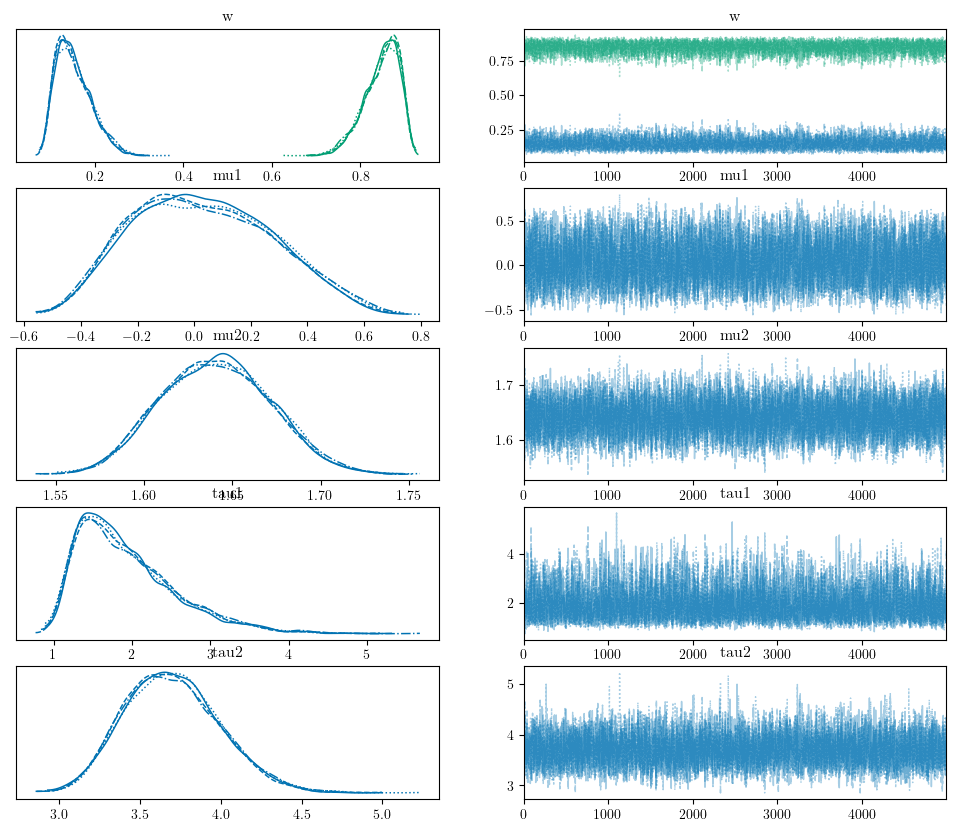

In [ ]:
az.plot_trace(trace, var_names=["w", "mu1","mu2", "tau1", "tau2"]);

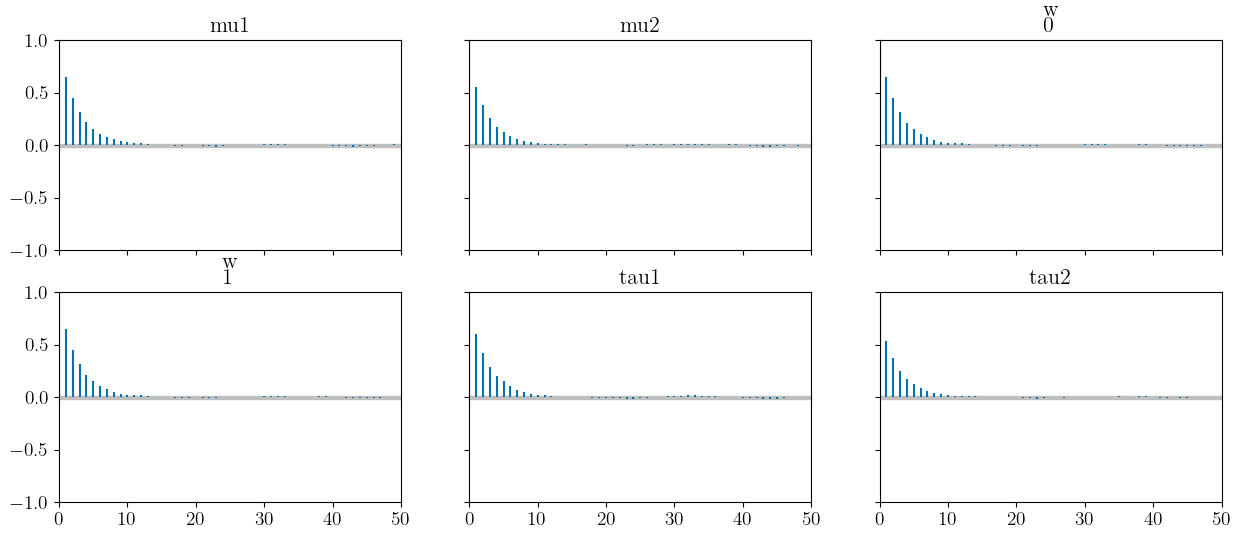

In [ ]:
az.plot_autocorr(trace, var_names=['w', 'mu1', 'mu2', 'tau1', 'tau2'], filter_vars="like",  max_lag=50,combined=True,figsize=(15, 6));
plt.show()

While not perfect, our autocorrelation plots look good enough that we feel confident proceeding.

In [ ]:
for var in ['mu1', 'mu2', 'tau1', 'tau2']:
    print(f"{var} ESS: {float(az.ess(trace, method='mean')[var]):.2f}")
print(f"w0 ESS: {float(az.ess(trace, method='mean')['w'][0]):.2f}")
print(f"w1 ESS: {float(az.ess(trace, method='mean')['w'][1]):.2f}")

mu1 ESS: 3806.73
mu2 ESS: 4398.82
tau1 ESS: 4071.58
tau2 ESS: 4524.65
w0 ESS: 3842.96
w1 ESS: 3842.96


Our ESSs look reasonable, so we proceed.

#### 3.4 Sensitivity Analysis
<a id='sensitivity'></a>

For our sensitivity analysis, we take our same model, but significantly flatten our priors. 

In [ ]:
# Mixture of Normal and Normal variables
with pm.Model() as model:
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # 2 mixture weights

    mu1 = pm.Normal("mu1", -10, 50)
    mu2 = pm.Normal("mu2", 10, 50)

    tau1 = pm.Gamma('tau1', alpha=1, beta=0.1)
    tau2 = pm.Gamma('tau2', alpha=1, beta=0.1)

    components = [
        pm.Normal.dist(mu=mu1, tau=tau1),
        pm.Normal.dist(mu=mu2, tau=tau2)
    ]

    like = pm.Mixture('like', w=w, comp_dists=components, observed=np.log10(times))
    idata = pm.sample_prior_predictive(samples=50)

Sampling: [like, mu1, mu2, tau1, tau2, w]


In [ ]:
with model:
      sens_trace = pm.sample(draws=5000,return_inferencedata=True,
                        chains=4, cores=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [w, mu1, mu2, tau1, tau2]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 44 seconds.
The acceptance probability does not match the target. It is 0.8813, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8948, but should be close to 0.8. Try to increase the number of tuning steps.


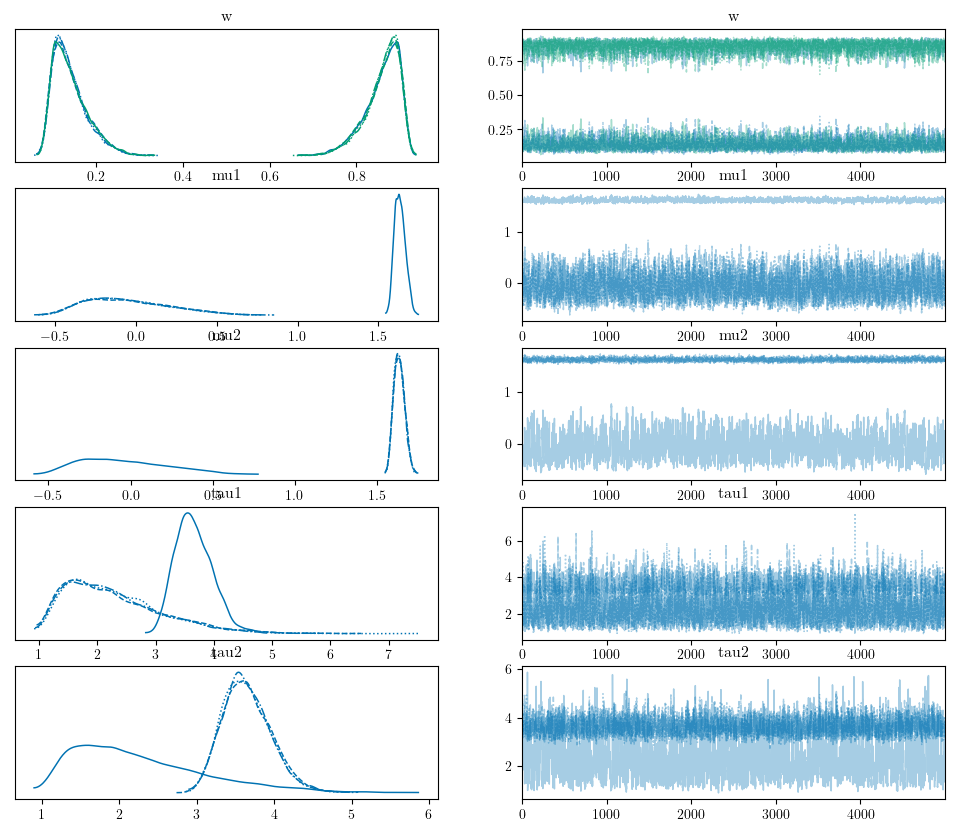

In [ ]:
az.plot_trace(sens_trace, var_names=["w", "mu1","mu2", "tau1", "tau2"]);

Even with these changes, we see a very similar posterior (excluding some reversals of $\mu_1$ and $\mu_2$). Thus, our model is robust to changes in prior.

#### 3.5 Posterior Predictive Check
<a id='ppc'></a>

We sample from the posterior in order to confirm that our model produces data that looks similar to the original.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, mu1, mu2, tau1, tau2]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 27 seconds.
Sampling: [like]


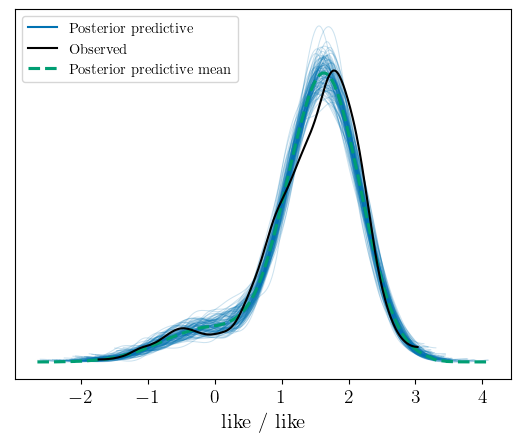

In [ ]:
with model:
    idata.extend(pm.sample(1000, tune=2000))

with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

az.plot_ppc(idata, num_pp_samples=100);

Our posterior predictive distribution looks very similar to the original data distribution.

### 4. Results
<a id='results'></a>

We now plot our posterior against the estimates of Zhang et. al. to compare.

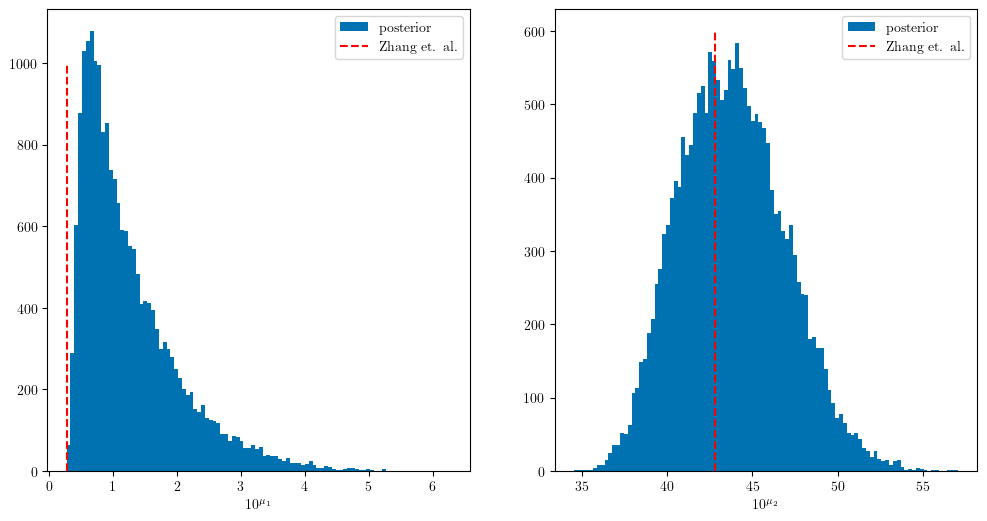

In [ ]:
mu1 = np.reshape(np.array(trace.posterior.mu1), -1)
mu2 = np.reshape(np.array(trace.posterior.mu2), -1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(10**mu1, bins=100, label='posterior')
ax[1].hist(10**mu2, bins=100, label='posterior')
ax[0].vlines(0.28, 0, 1000, linestyle='--', colors='r', label='Zhang et. al.')
ax[1].vlines(42.83, 0, 600, linestyle='--', colors='r', label='Zhang et. al.')
ax[0].set_xlabel("$10^{\mu_1}$")
ax[1].set_xlabel("$10^{\mu_2}$")
ax[0].legend()
ax[1].legend()
plt.show()

We see that while we have a similar estimate for $10^{\mu_2}$, our estimate for $10^{\mu_1}$ is siginficantly larger.

We now compute the distribution we are interested in, namely, the division between long and short GRBs. We do this by compuring the intersection of their gaussian curves using the quadratic formula. This gives us the point at which a random observation is equally likely to have come form a long or short GRB.

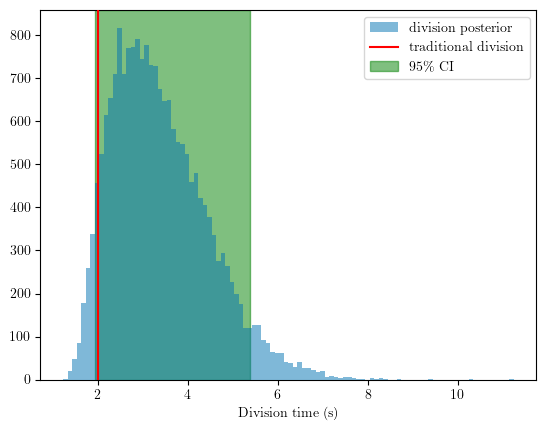

In [41]:
mu1 = np.reshape(np.array(trace.posterior.mu1), -1)
mu2 = np.reshape(np.array(trace.posterior.mu2), -1)
tau1 = np.reshape(np.array(trace.posterior.tau1), -1)
tau2 = np.reshape(np.array(trace.posterior.tau2), -1)
w = np.reshape(np.array(trace.posterior.w)[:, :, 0], -1)
var1 = 1/tau1
var2 = 1/tau2

# adapted from https://stats.stackexchange.com/questions/311592/how-to-find-the-point-where-two-normal-distributions-intersect
A = -tau1+tau2
B = 2*((-mu2/var2)+(mu1/var1))
C = mu2**2/var2-mu1**2/var1+np.log(var2/var1)+2*np.log(w/(1-w))

division = 10**((-B - np.sqrt(B**2-4*A*C))/(2*A))

post_05 = np.percentile(division, 5)
post_95 = np.percentile(division, 95)
plt.hist(division, alpha=0.5, bins=100, zorder=10,label='division posterior')
plt.xlabel("Division time (s)")
plt.axvline(x=2, color='red',zorder=1000, label='traditional division')
plt.axvspan(post_05, post_95, color='green', alpha=0.5, zorder=1, label='95\% CI')
plt.legend()
plt.show()

The accepted 2 second cutoff is just barely within the 95% credible interval of our distribution. This suggests that the traditional division between SGRBs and LGRBs may be supported by the data, but it isn't a definitive result. It may be beneficial to perform a similar analysis on the data from Zhang et. al. to see if the traditional division is supported by their data as well; one of their concerns was that the increased sensitivity of the Swift satellite may have rresulted in a shifting bias in the cutoff rate of short and long GRBs. The additional time we use for our analysis adds slightly more weight to this concern.

It's traditionally understood that, of the two classes of GRB, SGRBs are usually a result of kilonovae, whereas LGRBs occur due to supernovae. However, a study from this month by [Rastinejad et al. 2022](https://www.nature.com/articles/s41586-022-05390-w) in Nature suggests that this may not be the case. They find that an observed LGRB, GRB 211211A, may be associated with a kilonova event. This is a significant result, as it suggests that the traditional division between SGRBs and LGRBs may not be as clear-cut as we thought. A potentially exciting area of future study is cross-correlation of SGRB and LGRB rates compared to core-collapse supernova and compact merger event rates, and this is an area where Bayesian mixture models could reveal new information about our universe.